In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from fastai.tabular import *

In [3]:
path=Path('/kaggle/data_science_bowl')
path

PosixPath('/kaggle/data_science_bowl')

### Read Data

In [4]:
def read_data():
    train_df = pd.read_csv(path/'train.csv')
    test_df = pd.read_csv(path/'test.csv')
    train_labels_df = pd.read_csv(path/'train_labels.csv')
    sample_submission_df = pd.read_csv(path/'sample_submission.csv')
    return train_df, test_df, train_labels_df, sample_submission_df

In [5]:
train_df, test_df, train_labels_df, sample_submission_df = read_data()

In [6]:
train_df.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [7]:
test_df.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [8]:
train_labels_df.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


## Feature Engineering

In [9]:
def extract_time_features(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['year'] = df['timestamp'].dt.year
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['weekofyear'] = df['timestamp'].dt.weekofyear
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['quarter'] = df['timestamp'].dt.quarter
    df['is_month_start'] = df['timestamp'].dt.is_month_start    
    
    return df
    
def get_object_columns(df, columns):
    df = df.groupby(['installation_id', columns])['event_id'].count().reset_index()
    df = df.pivot_table(index = 'installation_id', columns = [columns], values = 'event_id')
    df.columns = list(df.columns)
    df.fillna(0, inplace = True)
    return df

agg_stats = ['mean', 'sum', 'min', 'max', 'std', 'skew', 'median']

def get_numeric_columns(df, column):
    df = df.groupby('installation_id').agg({f'{column}': agg_stats})
    df[column].fillna(df[column].mean(), inplace = True)
    df.columns = [f'{column}_{stat}' for stat in agg_stats]
    return df

def get_numeric_columns_add(df, agg_column, column):
    df = df.groupby(['installation_id', agg_column]).agg({f'{column}': agg_stats}).reset_index()
    df = df.pivot_table(index = 'installation_id', columns = [agg_column], values = [col for col in df.columns if col not in ['installation_id', agg_column]])
    df[column].fillna(df[column].mean(), inplace = True)
    df.columns = list(df.columns)
    return df

def perform_features_engineering(train_df, test_df, train_labels_df):
    print(f'Perform feature engineering')
    numerical_columns = ['game_time']
    categorical_columns = ['type', 'world']

    comp_train_df = pd.DataFrame({'installation_id': train_df['installation_id'].unique()})
    comp_train_df.set_index('installation_id', inplace = True)
    comp_test_df = pd.DataFrame({'installation_id': test_df['installation_id'].unique()})
    comp_test_df.set_index('installation_id', inplace = True)

    test_df = extract_time_features(test_df)
    train_df = extract_time_features(train_df)

    for i in numerical_columns:
        comp_train_df = comp_train_df.merge(get_numeric_columns(train_df, i), left_index = True, right_index = True)
        comp_test_df = comp_test_df.merge(get_numeric_columns(test_df, i), left_index = True, right_index = True)
    
    for i in categorical_columns:
        comp_train_df = comp_train_df.merge(get_object_columns(train_df, i), left_index = True, right_index = True)
        comp_test_df = comp_test_df.merge(get_object_columns(test_df, i), left_index = True, right_index = True)
    
    for i in categorical_columns:
        for j in numerical_columns:
            comp_train_df = comp_train_df.merge(get_numeric_columns_add(train_df, i, j), left_index = True, right_index = True)
            comp_test_df = comp_test_df.merge(get_numeric_columns_add(test_df, i, j), left_index = True, right_index = True)
    
    
    comp_train_df.reset_index(inplace = True)
    comp_test_df.reset_index(inplace = True)
    
    print('Our training set have {} rows and {} columns'.format(comp_train_df.shape[0], comp_train_df.shape[1]))

    # get the mode of the title
    labels_map = dict(train_labels_df.groupby('title')['accuracy_group'].agg(lambda x:x.value_counts().index[0]))
    # merge target
    labels = train_labels_df[['installation_id', 'title', 'accuracy_group']]
    # replace title with the mode
    labels['title'] = labels['title'].map(labels_map)
    # get title from the test set
    comp_test_df['title'] = test_df.groupby('installation_id').last()['title'].map(labels_map).reset_index(drop = True)
    # join train with labels
    comp_train_df = labels.merge(comp_train_df, on = 'installation_id', how = 'left')
    print('We have {} training rows'.format(comp_train_df.shape[0]))
    
    return comp_train_df, comp_test_df

In [10]:
comp_train_df, comp_test_df = perform_features_engineering(train_df, test_df, train_labels_df)

Perform feature engineering


/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


Our training set have 17000 rows and 72 columns


/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


We have 17690 training rows


In [11]:
comp_train_df = comp_train_df.fillna(0.)
comp_test_df = comp_test_df.fillna(0.)

In [12]:
pd.options.display.max_columns = None
comp_train_df

,installation_id,title,accuracy_group,game_time_mean,game_time_sum,game_time_min,game_time_max,game_time_std,game_time_skew,game_time_median,Activity,Assessment,Clip,Game,CRYSTALCAVES,MAGMAPEAK,NONE,TREETOPCITY,"(game_time, max, Activity)","(game_time, max, Assessment)","(game_time, max, Clip)","(game_time, max, Game)","(game_time, mean, Activity)","(game_time, mean, Assessment)","(game_time, mean, Clip)","(game_time, mean, Game)","(game_time, median, Activity)","(game_time, median, Assessment)","(game_time, median, Clip)","(game_time, median, Game)","(game_time, min, Activity)","(game_time, min, Assessment)","(game_time, min, Clip)","(game_time, min, Game)","(game_time, skew, Activity)","(game_time, skew, Assessment)","(game_time, skew, Clip)","(game_time, skew, Game)","(game_time, std, Activity)","(game_time, std, Assessment)","(game_time, std, Clip)","(game_time, std, Game)","(game_time, sum, Activity)","(game_time, sum, Assessment)","(game_time, sum, Clip)","(game_time, sum, Game)","(game_time, max, CRYSTALCAVES)","(game_time, max, MAGMAPEAK)","(game_time, max, NONE)","(game_time, max, TREETOPCITY)","(game_time, mean, CRYSTALCAVES)","(game_time, mean, MAGMAPEAK)","(game_time, mean, NONE)","(game_time, mean, TREETOPCITY)","(game_time, median, CRYSTALCAVES)","(game_time, median, MAGMAPEAK)","(game_time, median, NONE)","(game_time, median, TREETOPCITY)","(game_time, min, CRYSTALCAVES)","(game_time, min, MAGMAPEAK)","(game_time, min, NONE)","(game_time, min, TREETOPCITY)","(game_time, skew, CRYSTALCAVES)","(game_time, skew, MAGMAPEAK)","(game_time, skew, NONE)","(game_time, skew, TREETOPCITY)","(game_time, std, CRYSTALCAVES)","(game_time, std, MAGMAPEAK)","(game_time, std, NONE)","(game_time, std, TREETOPCITY)","(game_time, sum, CRYSTALCAVES)","(game_time, sum, MAGMAPEAK)","(game_time, sum, NONE)","(game_time, sum, TREETOPCITY)"
0,0006a69f,3,3,82491.007366,313548319,0,1520600,159789.192183,7.504204,50155.0,1771.0,261.0,37.0,1732.0,0.0,1910.0,4.0,1887.0,1520600.0,92799.0,0.0,232249.0,104714.852626,24886.245211,0.0,70209.587182,52767.0,16826.0,0.0,58727.0,0.0,0.0,0.0,0.0,5.459150,1.210442,0.0,0.864883,225262.351712,23754.712897,0.0,52702.709458,185450004.0,6495310.0,0.0,121603005.0,3.879622e+05,320531.0,0.0,1520600.0,101178.549937,63648.531937,0.0,101738.009009,89433.546653,46808.0,0.0,54010.0,0.0,0.0,0.0,0.0,0.527844,1.736113,0.0,5.704184,115847.423107,57216.164087,0.0,217683.232366,6.031041e+07,121568696.0,0.0,191979623.0
1,0006a69f,0,0,82491.007366,313548319,0,1520600,159789.192183,7.504204,50155.0,1771.0,261.0,37.0,1732.0,0.0,1910.0,4.0,1887.0,1520600.0,92799.0,0.0,232249.0,104714.852626,24886.245211,0.0,70209.587182,52767.0,16826.0,0.0,58727.0,0.0,0.0,0.0,0.0,5.459150,1.210442,0.0,0.864883,225262.351712,23754.712897,0.0,52702.709458,185450004.0,6495310.0,0.0,121603005.0,3.879622e+05,320531.0,0.0,1520600.0,101178.549937,63648.531937,0.0,101738.009009,89433.546653,46808.0,0.0,54010.0,0.0,0.0,0.0,0.0,0.527844,1.736113,0.0,5.704184,115847.423107,57216.164087,0.0,217683.232366,6.031041e+07,121568696.0,0.0,191979623.0
2,0006a69f,3,3,82491.007366,313548319,0,1520600,159789.192183,7.504204,50155.0,1771.0,261.0,37.0,1732.0,0.0,1910.0,4.0,1887.0,1520600.0,92799.0,0.0,232249.0,104714.852626,24886.245211,0.0,70209.587182,52767.0,16826.0,0.0,58727.0,0.0,0.0,0.0,0.0,5.459150,1.210442,0.0,0.864883,225262.351712,23754.712897,0.0,52702.709458,185450004.0,6495310.0,0.0,121603005.0,3.879622e+05,320531.0,0.0,1520600.0,101178.549937,63648.531937,0.0,101738.009009,89433.546653,46808.0,0.0,54010.0,0.0,0.0,0.0,0.0,0.527844,1.736113,0.0,5.704184,115847.423107,57216.164087,0.0,217683.232366,6.031041e+07,121568696.0,0.0,191979623.0
3,0006a69f,3,2,82491.007366,313548319,0,1520600,159789.192183,7.504204,50155.0,1771.0,261.0,37.0,1732.0,0.0,1910.0,4.0,1887.0,1520600.0,92799.0,0.0,232249.0,104714.852626,24886.245211,0.0,70209.587182,52767.0,16826.0,0.0,58727.0,0.0,0.0,0.0,0.0,5.459150,1.210442,0.0,0.864883,225262.351712,23754.712897,0.0,52702.709458,1854

In [13]:
list(comp_train_df.columns)

['installation_id',
 'title',
 'accuracy_group',
 'game_time_mean',
 'game_time_sum',
 'game_time_min',
 'game_time_max',
 'game_time_std',
 'game_time_skew',
 'game_time_median',
 'Activity',
 'Assessment',
 'Clip',
 'Game',
 'CRYSTALCAVES',
 'MAGMAPEAK',
 'NONE',
 'TREETOPCITY',
 ('game_time', 'max', 'Activity'),
 ('game_time', 'max', 'Assessment'),
 ('game_time', 'max', 'Clip'),
 ('game_time', 'max', 'Game'),
 ('game_time', 'mean', 'Activity'),
 ('game_time', 'mean', 'Assessment'),
 ('game_time', 'mean', 'Clip'),
 ('game_time', 'mean', 'Game'),
 ('game_time', 'median', 'Activity'),
 ('game_time', 'median', 'Assessment'),
 ('game_time', 'median', 'Clip'),
 ('game_time', 'median', 'Game'),
 ('game_time', 'min', 'Activity'),
 ('game_time', 'min', 'Assessment'),
 ('game_time', 'min', 'Clip'),
 ('game_time', 'min', 'Game'),
 ('game_time', 'skew', 'Activity'),
 ('game_time', 'skew', 'Assessment'),
 ('game_time', 'skew', 'Clip'),
 ('game_time', 'skew', 'Game'),
 ('game_time', 'std', 'Activ

In [14]:
list(comp_test_df.columns)

['installation_id',
 'game_time_mean',
 'game_time_sum',
 'game_time_min',
 'game_time_max',
 'game_time_std',
 'game_time_skew',
 'game_time_median',
 'Activity',
 'Assessment',
 'Clip',
 'Game',
 'CRYSTALCAVES',
 'MAGMAPEAK',
 'NONE',
 'TREETOPCITY',
 ('game_time', 'max', 'Activity'),
 ('game_time', 'max', 'Assessment'),
 ('game_time', 'max', 'Clip'),
 ('game_time', 'max', 'Game'),
 ('game_time', 'mean', 'Activity'),
 ('game_time', 'mean', 'Assessment'),
 ('game_time', 'mean', 'Clip'),
 ('game_time', 'mean', 'Game'),
 ('game_time', 'median', 'Activity'),
 ('game_time', 'median', 'Assessment'),
 ('game_time', 'median', 'Clip'),
 ('game_time', 'median', 'Game'),
 ('game_time', 'min', 'Activity'),
 ('game_time', 'min', 'Assessment'),
 ('game_time', 'min', 'Clip'),
 ('game_time', 'min', 'Game'),
 ('game_time', 'skew', 'Activity'),
 ('game_time', 'skew', 'Assessment'),
 ('game_time', 'skew', 'Clip'),
 ('game_time', 'skew', 'Game'),
 ('game_time', 'std', 'Activity'),
 ('game_time', 'std', 

## Normalize

In [15]:
comp_train_df.columns = [c if type(c) != tuple else '_'.join(c) for c in comp_train_df.columns]

In [16]:
comp_test_df.columns = [c if type(c) != tuple else '_'.join(c) for c in comp_test_df.columns]

In [17]:
comp_train_df.columns = [re.sub(r'\W', '_', s) for s in comp_train_df.columns]

In [18]:
comp_test_df.columns = [re.sub(r'\W', '_', s) for s in comp_test_df.columns]

In [19]:
list(comp_train_df.columns)

['installation_id',
 'title',
 'accuracy_group',
 'game_time_mean',
 'game_time_sum',
 'game_time_min',
 'game_time_max',
 'game_time_std',
 'game_time_skew',
 'game_time_median',
 'Activity',
 'Assessment',
 'Clip',
 'Game',
 'CRYSTALCAVES',
 'MAGMAPEAK',
 'NONE',
 'TREETOPCITY',
 'game_time_max_Activity',
 'game_time_max_Assessment',
 'game_time_max_Clip',
 'game_time_max_Game',
 'game_time_mean_Activity',
 'game_time_mean_Assessment',
 'game_time_mean_Clip',
 'game_time_mean_Game',
 'game_time_median_Activity',
 'game_time_median_Assessment',
 'game_time_median_Clip',
 'game_time_median_Game',
 'game_time_min_Activity',
 'game_time_min_Assessment',
 'game_time_min_Clip',
 'game_time_min_Game',
 'game_time_skew_Activity',
 'game_time_skew_Assessment',
 'game_time_skew_Clip',
 'game_time_skew_Game',
 'game_time_std_Activity',
 'game_time_std_Assessment',
 'game_time_std_Clip',
 'game_time_std_Game',
 'game_time_sum_Activity',
 'game_time_sum_Assessment',
 'game_time_sum_Clip',
 'game_

## Training

In [30]:
dep_var = 'accuracy_group'
cat_names = []
cont_names = [c for c in comp_train_df.columns if c not in ['accuracy_group', 'installation_id']]
procs = [FillMissing, Categorify, Normalize]

In [31]:
test_data = TabularList.from_df(comp_test_df[cont_names], cat_names=cat_names, cont_names=cont_names)

In [32]:
data = (TabularList.from_df(comp_train_df, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_rand_pct()
                           .label_from_df(cols=dep_var)
                           .add_test(test_data)
                           .databunch())

In [33]:
data.show_batch(rows=10)

title,game_time_mean,game_time_sum,game_time_min,game_time_max,game_time_std,game_time_skew,game_time_median,Activity,Assessment,Clip,Game,CRYSTALCAVES,MAGMAPEAK,NONE,TREETOPCITY,game_time_max_Activity,game_time_max_Assessment,game_time_max_Clip,game_time_max_Game,game_time_mean_Activity,game_time_mean_Assessment,game_time_mean_Clip,game_time_mean_Game,game_time_median_Activity,game_time_median_Assessment,game_time_median_Clip,game_time_median_Game,game_time_min_Activity,game_time_min_Assessment,game_time_min_Clip,game_time_min_Game,game_time_skew_Activity,game_time_skew_Assessment,game_time_skew_Clip,game_time_skew_Game,game_time_std_Activity,game_time_std_Assessment,game_time_std_Clip,game_time_std_Game,game_time_sum_Activity,game_time_sum_Assessment,game_time_sum_Clip,game_time_sum_Game,game_time_max_CRYSTALCAVES,game_time_max_MAGMAPEAK,game_time_max_NONE,game_time_max_TREETOPCITY,game_time_mean_CRYSTALCAVES,game_time_mean_MAGMAPEAK,game_time_mean_NONE,game_time_mean_TREETOPCITY,game_time_median_CRYSTALCAVES,game_time_median_MAGMAPEAK,game_time_median_NONE,game_time_median_TREETOPCITY,game_time_min_CRYSTALCAVES,game_time_min_MAGMAPEAK,game_time_min_NONE,game_time_min_TREETOPCITY,game_time_skew_CRYSTALCAVES,game_time_skew_MAGMAPEAK,game_time_skew_NONE,game_time_skew_TREETOPCITY,game_time_std_CRYSTALCAVES,game_time_std_MAGMAPEAK,game_time_std_NONE,game_time_std_TREETOPCITY,game_time_sum_CRYSTALCAVES,game_time_sum_MAGMAPEAK,game_time_sum_NONE,game_time_sum_TREETOPCITY,target
0.6911,-0.2452,-0.5203,0.0000,-0.1973,-0.1865,-0.3965,-0.5784,-0.7250,-0.6248,-0.5075,-0.5526,-0.5946,-0.7286,-0.2097,-0.5673,-0.2725,-0.0735,0.0000,-0.1681,0.0572,-0.1625,0.0000,-0.2873,1.0858,-0.4333,0.0000,-1.0592,0.0000,0.0000,0.0000,0.0000,-0.5383,-0.4720,0.0000,-0.5644,-0.2027,-0.1190,0.0000,-0.1612,-0.4161,-0.1941,0.0000,-0.4595,-0.2527,-0.1292,0.0000,-0.0987,-0.3808,-0.1465,0.0000,0.0474,-0.7420,-0.1449,0.0000,1.7701,0.0000,0.0000,0.0000,0.0000,-0.5297,-0.3149,0.0000,-0.4837,-0.2807,-0.1256,0.0000,-0.0654,-0.4362,-0.3503,0.0000,-0.3402,3
-1.4468,-0.3080,-0.5006,0.0000,-0.2047,-0.2169,-0.5146,-0.5524,-0.5696,-0.4507,-0.5173,-0.5241,-0.6552,-0.5801,-0.3043,-0.4296,-0.3006,-0.0651,0.0000,-0.1609,-0.2935,-0.0392,0.0000,-0.1996,-0.3950,0.5169,0.0000,-0.4550,0.0000,0.0000,0.0000,0.0000,-0.3543,-0.4054,0.0000,-0.4824,-0.2799,-0.0901,0.0000,-0.1452,-0.4105,-0.1530,0.0000,-0.4436,-0.2378,-0.1739,0.0000,-0.1102,-0.2380,-0.4022,0.0000,-0.0934,-0.1398,-0.4425,0.0000,-0.1501,0.0000,0.0000,0.0000,0.0000,-0.6143,-0.3249,0.0000,-0.3532,-0.2518,-0.2755,0.0000,-0.0974,-0.4345,-0.4375,0.0000,-0.3328,0
-1.4468,-0.2249,-0.4281,0.0000,-0.1893,-0.1894,-0.3247,-0.3227,-0.4563,-0.3109,-0.1849,-0.3657,-0.4381,-0.3708,-0.2097,-0.3956,-0.2422,-0.0672,0.0000,-0.1546,-0.1353,-0.1002,0.0000,-0.1588,-0.1964,-0.0372,0.0000,-0.2510,0.0000,0.0000,0.0000,0.0000,-0.1454,-0.2909,0.0000,-0.4001,-0.1830,-0.1029,0.0000,-0.1376,-0.3424,-0.1487,0.0000,-0.3814,-0.2192,-0.1510,0.0000,-0.1116,-0.1967,-0.1969,0.0000,-0.1126,-0.1009,-0.0725,0.0000,-0.3056,0.0000,0.0000,0.0000,0.0000,-0.4123,-0.2080,0.0000,-0.3340,-0.2278,-0.2080,0.0000,-0.1043,-0.3682,-0.3489,0.0000,-0.3363,0
0.6911,-0.2744,-0.4860,0.0000,-0.1982,-0.2070,-0.4156,-0.4041,-0.5835,-0.5683,-0.4391,-0.4447,-0.6462,-0.3704,-0.3990,-0.5953,-0.2950,-0.0713,0.0000,-0.1514,-0.3034,-0.1267,0.0000,-0.1720,-0.4762,-0.1294,0.0000,-0.4758,0.0000,0.0000,0.0000,0.0000,-0.2785,-0.4707,0.0000,-0.2345,-0.2760,-0.1108,0.0000,-0.1359,-0.4151,-0.1861,0.0000,-0.4132,-0.2485,-0.1642,0.0000,-0.1176,-0.3583,-0.3276,0.0000,-0.1422,-0.6650,-0.2152,0.0000,-0.9043,0.0000,0.0000,0.0000,0.0000,-0.4974,-0.2521,0.0000,-0.3254,-0.2741,-0.2608,0.0000,-0.1099,-0.4414,-0.3799,0.0000,-0.3856,2
0.6911,-0.2005,-0.2416,0.0000,-0.1568,-0.1639,-0.1577,-0.5611,0.3327,1.1392,0.5385,-0.4004,-0.2612,0.2790,1.0204,-0.0017,-0.1192,-0.0332,0.0000,-0.1438,-0.0564,-0.0344,0.0000,-0.1097,0.0248,0.0142,0.0000,-0.1526,0.0000,0.0000,0.0000,0.0000,0.0878,0.0578,0.0000,-0.3245,-0.1344,-0

In [34]:
# quadratic weighted kappa
def qwk3(a1, a2, max_rat=3):
    '''
    a1 - ground truth
    a2 - predicted values
    '''
    a1 = a1.argmax(1)
    tmp = a1
    a1 = a2
    a2 = tmp
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)
    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))
    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)
    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)
    e = e / a1.shape[0]
    return tensor(1 - o / e)

In [35]:
metrics = [accuracy, qwk3]

In [76]:
from fastai import callbacks

learn = tabular_learner(data, layers=[1600, 800, 400, 200, 100], metrics=metrics)

In [77]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=72, out_features=1600, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=1600, out_features=800, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=800, out_features=400, bias=True)
    (7): ReLU(inplace=True)
    (8): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=400, out_features=200, bias=True)
    (10): ReLU(inplace=True)
    (11): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=200, out_features=100, bias=True)
    (13): ReL

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


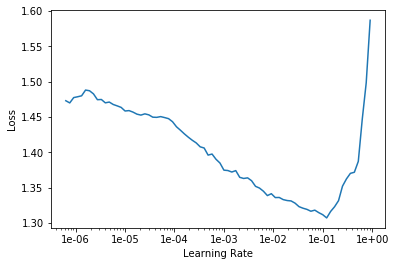

In [78]:
lr_find(learn)
learn.recorder.plot()

In [79]:
learn.fit_one_cycle(50, 1e-03, callbacks=[callbacks.SaveModelCallback(learn, monitor='qwk3',mode='max', name='best_model')])

epoch,train_loss,valid_loss,accuracy,qwk3,time
0,1.186906,1.178359,0.561051,0.469204,00:02
1,1.155335,1.144270,0.588468,0.470475,00:02
2,1.125482,1.113642,0.585924,0.475664,00:02
3,1.104167,1.111539,0.586207,0.460140,00:02
4,1.077626,1.083664,0.579141,0.452751,00:02
5,1.060477,1.084690,0.585076,0.461307,00:02
6,1.052256,1.100315,0.587903,0.468530,00:02
7,1.054824,1.102083,0.588185,0.466412,00:02
8,1.056263,1.104773,0.583380,0.447658,00:02
9,1.064628,1.071954,0.582533,0.455421,00:02


Better model found at epoch 0 with qwk3 value: 0.46920377016067505.
Better model found at epoch 1 with qwk3 value: 0.47047537565231323.
Better model found at epoch 2 with qwk3 value: 0.47566357254981995.
Better model found at epoch 11 with qwk3 value: 0.475882887840271.
Better model found at epoch 12 with qwk3 value: 0.480924516916275.
Better model found at epoch 17 with qwk3 value: 0.48998963832855225.
Better model found at epoch 25 with qwk3 value: 0.49053969979286194.
Better model found at epoch 26 with qwk3 value: 0.49144017696380615.
Better model found at epoch 30 with qwk3 value: 0.49669110774993896.
Better model found at epoch 37 with qwk3 value: 0.5017287731170654.


## Inference

In [109]:
all_probs = learn.get_preds(ds_type=DatasetType.Test)

In [130]:
y_pred = all_probs[0]

In [131]:
np.unique(y_pred.argmax(-1), return_counts=True)

(array([0, 1, 2, 3]), array([254,  33,  21, 692]))

In [132]:
def prepare_submission(comp_test_df, sample_submission_df, y_pred):
    comp_test_df = comp_test_df.reset_index()
    comp_test_df = comp_test_df[['installation_id']]
    comp_test_df['accuracy_group'] = y_pred.argmax(axis = 1)
    sample_submission_df.drop('accuracy_group', inplace = True, axis = 1)
    sample_submission_df = sample_submission_df.merge(comp_test_df, on = 'installation_id')
    sample_submission_df.to_csv('submission.csv', index = False)

In [133]:
prepare_submission(comp_test_df, sample_submission_df, y_pred)

In [134]:
!head submission.csv

installation_id,accuracy_group
00abaee7,3
01242218,3
017c5718,3
01a44906,3
01bc6cb6,3
02256298,3
0267757a,3
027e7ce5,2
02a29f99,1
